In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from textblob import TextBlob
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import yfinance as yf
import warnings
from pandas.tseries.offsets import DateOffset
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# Ignore all warnings within this code block
warnings.filterwarnings("ignore")

In [3]:
## Acquire and process sentiment data from Kaggle
sentiment_df=pd.read_csv(Path("../Resources/combined_csv.csv"))
sentiment_df.head()

,Time,Headline,SP500 Close,Volume,TSLA Close,Volume.1
0,2017-12-18,Brace yourself for the next Brexit faultline: ...,268.200012,83653600.0,22.591333,82143000.0
1,2017-12-19,"First pilots, now cabin crew – Ryanair to reco...",267.170013,82382900.0,22.073334,102375000.0
2,2017-12-20,"Nearly 45,000 UK retailers in financial distre...",267.029999,76751500.0,21.931999,89307000.0
3,2017-12-21,Last-minute Christmas shopping guide: there is...,267.579987,67032300.0,22.110666,65778000.0
4,2017-12-22,Cramer: Never buy a stock all at once — you'll...,267.510010,78720900.0,21.680000,63237000.0


In [3]:
# obtain polarity and subjectivity scores (potentially factor volume of information in the sentiment analysis)

# create a function to calculate the subjectivity
def calculate_subjectivity(headlines):
    return TextBlob(headlines).sentiment.subjectivity

# create a function to calculate the subjectivity
def calculate_polarity(headlines):
    return TextBlob(headlines).sentiment.polarity


In [4]:
# create two new columns "Subjectivity" and "Polarity"
sentiment_df["Subjectivity"] = sentiment_df["Headline"].apply(calculate_subjectivity)
sentiment_df["Polarity"] = sentiment_df["Headline"].apply(calculate_polarity)

In [5]:
# create function to get the sentiment scores 
def get_scores(headlines):
    get_score= SentimentIntensityAnalyzer()
    sentiment=get_score.polarity_scores(headlines)
    return sentiment

In [6]:
# get daily sentiment scores
compound = []
neg = []
pos = []
neu = []
score = 0

for x in range(0, len(sentiment_df["Headline"])):
    score = get_scores(sentiment_df["Headline"][x])
    compound.append(score["compound"])
    neg.append(score["neg"])
    neu.append(score["neu"])
    pos.append(score["pos"])
    

In [7]:
# Add Column with sentiment scores
sentiment_df["compound"]= compound
sentiment_df["neg"]= neg
sentiment_df["pos"]= pos
sentiment_df["neu"]= neu

#Display Dataframe
sentiment_df

,Time,Headline,SP500 Close,Volume,TSLA Close,Volume.1,Subjectivity,Polarity,compound,neg,pos,neu
0,2017-12-18,Brace yourself for the next Brexit faultline: ...,268.200012,83653600.0,22.591333,82143000.0,0.349438,-0.000624,-0.9425,0.122,0.075,0.804
1,2017-12-19,"First pilots, now cabin crew – Ryanair to reco...",267.170013,82382900.0,22.073334,102375000.0,0.303711,-0.043869,-0.9760,0.127,0.027,0.846
2,2017-12-20,"Nearly 45,000 UK retailers in financial distre...",267.029999,76751500.0,21.931999,89307000.0,0.405042,-0.020270,-0.8761,0.104,0.077,0.818
3,2017-12-21,Last-minute Christmas shopping guide: there is...,267.579987,67032300.0,22.110666,65778000.0,0.522302,-0.036371,0.4404,0.094,0.113,0.793
4,2017-12-22,Cramer: Never buy a stock all at once — you'll...,267.510010,78720900.0,21.680000,63237000.0,0.429320,0.038917,-0.2362,0.096,0.108,0.797
...,...,...,...,...,...,...,...,...,...,...,...,...
642,2020-07-13,"Luckin Coffee ousts chairman Lu, names Guo as ...",314.839996,102997500.0,99.804001,584781000.0,0.414809,0.140556,0.9773,0.100,0.123,0.777
643,2020-07-14,"Google hit with 600,000 euro Belgian privacy f...",318.920013,93657000.0,101.120003,351271500.0,0.345320,0.057631,-0.9830,0.104,0.082,0.814
644,2020-07-15,Oil climbs 2% on U.S. stock draw but gains cap...,321.850006,87196500.0,103.067329,245517000.0,0.387709,0.012013,0.5514,0.127,0.128,0.745
645,2020-07-16,Morgan Stanley posts record profit on trading ...,320.790009,54622500.0,100.042664,214512000.0,0.393206,0.088800,-0.9979,0.141,0.088,0.771


In [8]:
# # Calculate daily returns 
# sentiment_df["daily returns"]= sentiment_df["TSLA Close"].pct_change()
# sentiment_df.drop(columns=["SP500 Close", "Volume"], inplace = True)
# sentiment_df= sentiment_df.set_index("Time")
# sentiment_df.index= pd.to_datetime(sentiment_df.index)

In [9]:
# # Calculate daily returns 
sentiment_df["daily returns"]= sentiment_df["SP500 Close"].pct_change()
sentiment_df.drop(columns=["TSLA Close", "Volume.1"], inplace = True)
sentiment_df= sentiment_df.set_index("Time")
sentiment_df.index= pd.to_datetime(sentiment_df.index)

In [10]:
# create label column add 1 when daily returns is positive and 0 when it is negative
sentiment_df["label"]= 0
sentiment_df.loc[(sentiment_df["daily returns"]> 0), 'label'] = 1

# verify that label is int
sentiment_df["label"].dtype

dtype('int64')

In [11]:
# # # calculate SMA short and SMA slow for SP500
# sentiment_df["sma_short"]= sentiment_df.rolling(7)["TSLA Close"].mean()
# sentiment_df["sma_long"]= sentiment_df.rolling(30)["TSLA Close"].mean()
# sentiment_df.dropna(inplace=True)

In [12]:
# calculate SMA short and SMA slow for just TSLA
sentiment_df["sma_short"]= sentiment_df.rolling(21)["SP500 Close"].mean()
sentiment_df["sma_long"]= sentiment_df.rolling(90)["SP500 Close"].mean()
sentiment_df.dropna(inplace=True)

In [13]:
# display dataframe
sentiment_df.columns

Index(['Headline', 'SP500 Close', 'Volume', 'Subjectivity', 'Polarity',
       'compound', 'neg', 'pos', 'neu', 'daily returns', 'label', 'sma_short',
       'sma_long'],
      dtype='object')

In [14]:
# create features variable with columns for X
# TSLA Version
# features=['Volume.1', 'Subjectivity', 'Polarity',
#        'compound', 'neg', 'pos', 'neu', 'sma_short',
#        'sma_long']

# X = sentiment_df[features].shift().dropna().copy()
# X.tail()

#SP500 Version
# create features variable with columns for X
features=['Volume', 'Subjectivity', 'Polarity',
       'compound', 'neg', 'pos', 'neu', 'sma_short',
       'sma_long']

X = sentiment_df[features].shift().dropna().copy()
X.tail()

,Volume,Subjectivity,Polarity,compound,neg,pos,neu,sma_short,sma_long
Time,,,,,,,,,
2020-07-13,57550400.0,0.368474,0.074615,-0.4037,0.100,0.103,0.797,309.791424,287.309555
2020-07-14,102997500.0,0.414809,0.140556,0.9773,0.100,0.123,0.777,310.469044,287.331555
2020-07-15,93657000.0,0.345320,0.057631,-0.9830,0.104,0.082,0.814,311.169521,287.514444
2020-07-16,87196500.0,0.387709,0.012013,0.5514,0.127,0.128,0.745,311.874284,287.785444
2020-07-17,54622500.0,0.393206,0.088800,-0.9979,0.141,0.088,0.771,312.247142,288.302777


In [15]:
y=(sentiment_df['daily returns']>0).astype(int)[1:]

In [16]:
# verify x and y are same length

display(len(X))
display(len(y))

557

557

In [17]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

# Select the ending period for the training data with an offset of 3 months
training_end = X.index.min() + DateOffset(months=24)

# Display the training end date
print(training_end)

# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
X_train.head()

# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(hours=1):]
y_test = y.loc[training_end+DateOffset(hours=1):]

X_train['Volume'] = X_train['Volume'] * 2
# X_train['Volume.1'] = X_train['Volume.1'] * 2
X_train['Subjectivity'] = X_train['Subjectivity'] * 2
X_train['Polarity'] = X_train['Polarity'] *2
X_train['pos'] = X_train['pos'] *2
X_train['neg'] = X_train['neg'] *2


# Review the X_test DataFrame
X_train.head()

2018-05-02 00:00:00
2020-05-02 00:00:00


,Volume,Subjectivity,Polarity,compound,neg,pos,neu,sma_short,sma_long
Time,,,,,,,,,
2018-05-02,148406800.0,0.915761,0.150033,0.6777,0.180,0.200,0.811,265.220478,270.549888
2018-05-03,172737800.0,0.844568,0.064671,0.9495,0.182,0.230,0.794,265.336193,270.494333
2018-05-04,272623000.0,0.736671,-0.031137,-0.9915,0.280,0.184,0.768,265.291431,270.443777
2018-05-07,182444200.0,0.767589,0.107363,-0.7620,0.288,0.266,0.724,265.309525,270.432555
2018-05-08,110609800.0,0.686658,0.071556,-0.9936,0.290,0.158,0.776,265.652383,270.425222


In [18]:
## Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [19]:
# Import Gaussian Naive Bayes classifier
from sklearn.naive_bayes import GaussianNB

# Instantiate Gaussian Naive Bayes model
nb_model = GaussianNB()

# Fit the model to the data using the training data
nb_model = nb_model.fit(X_train_scaled, y_train)

# Use the testing data to make the model predictions
nb_pred = nb_model.predict(X_test_scaled)

# Review the model's predicted values
nb_pred[:10]

# Use a classification report to evaluate the model using the predictions and testing data
nb_testing_report = classification_report(y_test, nb_pred)

# Print the classification report
print(nb_testing_report)


              precision    recall  f1-score   support

           0       1.00      0.06      0.11        18
           1       0.67      1.00      0.80        35

    accuracy                           0.68        53
   macro avg       0.84      0.53      0.45        53
weighted avg       0.78      0.68      0.57        53



In [20]:
# Create a predictions DataFrame
predictions_sentiment_df = pd.DataFrame(index=X_test.index)

# Add the Naive Bayes model predictions to the DataFrame
predictions_sentiment_df['Predicted'] = nb_pred

# Add the actual returns to the DataFrame
predictions_sentiment_df['Actual Returns'] = sentiment_df['daily returns']

# Add the strategy returns to the DataFrame
predictions_sentiment_df['Strategy Returns'] = predictions_sentiment_df['Actual Returns'] * predictions_sentiment_df['Predicted']

# Review the DataFrame
predictions_sentiment_df.head()

,Predicted,Actual Returns,Strategy Returns
Time,,,
2020-05-04,1,0.002758,0.002758
2020-05-05,1,0.009239,0.009239
2020-05-06,1,-0.006779,-0.006779
2020-05-07,1,0.012067,0.012067
2020-05-08,1,0.016546,0.016546


<Axes: title={'center': 'Naive Bayes Model'}, xlabel='Time'>

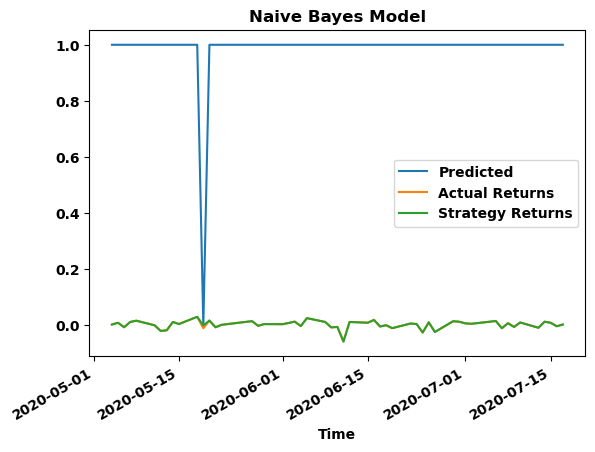

In [21]:
predictions_sentiment_df.plot(title='Naive Bayes Model')

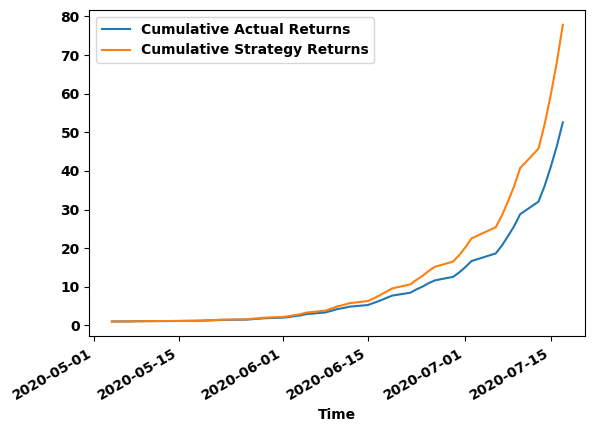

In [22]:
# Calculate cumulative actual returns
predictions_sentiment_df['Cumulative Actual Returns'] = predictions_sentiment_df['Actual Returns'].cumsum()

# Calculate cumulative strategy returns
predictions_sentiment_df['Cumulative Strategy Returns'] = predictions_sentiment_df['Strategy Returns'].cumsum()

# Plot the cumulative returns
# predictions_sentiment_df[['Cumulative Actual Returns', 'Cumulative Strategy Returns']].plot(title='Cumulative Returns')
linear_disc_plot = (1 + predictions_sentiment_df[["Cumulative Actual Returns", "Cumulative Strategy Returns"]]).cumprod().plot()